In [117]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Token, Doc
from spacy.attrs import LOWER, IS_ALPHA, LEMMA
# !python -m spacy download en_core_web_sm  # à télécharger en ligne de commande
from spacy.lang.en import English

import re
import csv
import numpy as np
import pandas as pd
import time
import random
import string

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, hamming_loss, f1_score
from sklearn.feature_extraction.text import CountVectorizer

import math
from operator import itemgetter 
from collections import Counter
from joblib import dump, load
import matplotlib.pyplot as plt
import copy

# Functions

In [47]:
def shuffle_lists(list_data, list_labels):
    shuff = list(zip(list_data, list_labels))
    random.shuffle(shuff)
    list_data, list_labels = zip(*shuff)
    return list_data, list_labels


# lit le fichier de train, retourne la liste des data et la liste des labels associée
# les labels sont transformés pour faire du single label
def read_csv_single_label(path):
    list_data = []
    list_labels = []
    with open(path, 'r', encoding="utf8") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for line in reader:
            if reader.line_num != 1:
                # on obtient tous les indices où se trouvent les 1 (labels)
                # on crée une ligne pour chaque indice
                # s'il n'y a pas d'indice, alors on ajoute le label 6 (que des 0)
                index_list = [i for i, value in enumerate(line[2:]) if value == "1"]
                nb_labels = len(index_list)
                if nb_labels == 0:
                    list_data.append(line[1])
                    list_labels.append(6)
                else:
                    list_data.extend([line[1]] * nb_labels)
                    list_labels.extend(index_list)
    # on mélange les exemples
    list_data, list_labels = shuffle_lists(list_data, list_labels)
    return list_data, list_labels


# lit les deux fichiers de test
# transforme les data en single label
def read_csv_test_single(path_data, path_label):
    data_test = pd.read_csv(path_data)
    labels_test = pd.read_csv(path_label)
    # supression des lignes dont les labels sont -1
    ind_to_delete = labels_test.index[labels_test['toxic'] == -1].tolist() 
    data_test = data_test.drop(ind_to_delete, axis=0)
    labels_test = labels_test.drop(ind_to_delete, axis=0)
    # suppression de la première colonne (identifiant) dans data_test et labels_test
    data_test = data_test.drop(columns=['id'])
    labels_test = labels_test.drop(columns=['id'])
    # transformer labels_test pour avoir du single label
    list_data = []
    list_labels = []
    for i in range(len(data_test)):
        zero = True
        for j in range(6):
            if labels_test.iloc[i, j] == 1:
                zero = False
                list_data.append(data_test.iloc[i, 0])
                list_labels.append(j)
        if zero:
            list_data.append(data_test.iloc[i, 0])
            list_labels.append(6)
    return list_data, list_labels


# lit les deux fichiers de test
def read_csv_test_multi(path_data, path_label):
    data_test = pd.read_csv(path_data)
    labels_test = pd.read_csv(path_label)
    # supression des lignes dont les labels sont -1
    ind_to_delete = labels_test.index[labels_test['toxic'] == -1].tolist() 
    data_test = data_test.drop(ind_to_delete, axis=0)
    labels_test = labels_test.drop(ind_to_delete, axis=0)
    # suppression de la première colonne (identifiant) dans data_test et labels_test
    data_test = data_test.drop(columns=['id'])
    labels_test = labels_test.drop(columns=['id'])
    list_data = data_test.iloc[:, 0].to_list()
    list_labels = labels_test.values.tolist()
    return list_data, list_labels


In [3]:
# SpaCy functions

# fait partie du pipeline de spacy
# enlève les stopwords, ponctuations, nombres
# garde les racines (lemmas) des mots
def remove_tokens(doc):
    indexes = []
    letters = r"([\w]+)"
    numbers = r"([0-9]+)"
    # déterminer les mots à enlever
    for index, token in enumerate(doc):
        not_stopword = token.lemma_ not in stopwords
        not_punctuation = token.lemma_ not in string.punctuation  # or token.lemma_ == "!"
        not_number = re.match(numbers, token.lemma_) is None
        keepit = not_stopword and re.match(letters, token.text) is not None and not_number and not_punctuation
        if not keepit:
            indexes.append(index)
    # supprimer les mots non nécessaires
    np_array = doc.to_array([LOWER, IS_ALPHA, LEMMA])  
    np_array = np.delete(np_array, indexes, axis=0)
    doc2 = Doc(doc.vocab, words=[t.text for ind, t in enumerate(doc) if ind not in indexes])
    doc2.from_array([LOWER, IS_ALPHA, LEMMA], np_array)
    return doc2


# amélioration possible : enlever les _ et les # qui sont à l'intérieur d'un mot
# renvoie une liste de strings composées de lemmas et sans les stopwords, ponctuations... 
def spacy_processing(list_data, pipeline):
    with pipeline.disable_pipes("tagger", "parser"):
        docs = list(pipeline.pipe(list_data))
    for i in range(len(docs)): 
        docs[i] = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in docs[i]]
        docs[i] = ' '.join(docs[i])
    return docs

# Lecture et transformation des documents

## Lecture et stats

In [4]:
# lecture du jeu de train
path = 'data/train.csv'
list_data_train, list_labels_train = read_csv_single_label(path)
print("reading done ")
np_labels_train = np.asarray(list_labels_train)  

reading done 


In [5]:
# lecture du jeu de test
path_data_test = 'data/test.csv'
path_labels_test = 'data/test_labels.csv'

t0 = time.time()
list_data_test, list_labels_test = read_csv_test_single(path_data_test, path_labels_test)   
t1 = time.time()
print(t1-t0)
np_labels_test = np.asarray(list_labels_test) 

9.344231128692627


In [48]:
# lecture du jeu de test pour obtenir la hamming_loss
path_data_test = 'data/test.csv'
path_labels_test = 'data/test_labels.csv'

t0 = time.time()
list_data_test_hamming, list_labels_test_hamming = read_csv_test_multi(path_data_test, path_labels_test)
t1 = time.time()
print(t1-t0)
np_labels_test_hamming = np.asarray(list_labels_test_hamming)

1.6745884418487549


In [212]:
# stats sur les labels d'entraînement 
(unique, counts) = np.unique(np_labels_train, return_counts=True, axis=0)
counts = counts / np_labels_train.shape[0]
print("frequency : ")
for i in range(unique.shape[0]):
    print(unique[i], counts[i])

frequency : 
0 0.08570756091546929
1 0.008938378426845396
2 0.04734818766671897
3 0.002678711528546771
4 0.04414270023088476
5 0.007873618614243124
6 0.8033108426172917


In [213]:
# stats sur les labels d'entraînement sans la classe non toxique
(unique, counts) = np.unique(np_labels_train, return_counts=True, axis=0)
counts = counts / (np_labels_train.shape[0] - counts[6])
for i in range(unique.shape[0] - 1):
    print(unique[i], counts[i])

0 0.4357513248618155
1 0.045444184853837825
2 0.24072596729158358
3 0.013619009630178357
4 0.2244287423784831
5 0.04003077098410166


In [43]:
# stats sur les labels de test
(unique, counts) = np.unique(np_labels_test, return_counts=True, axis=0)
counts = counts / np_labels_test.shape[0]
print("frequency : ")
for i in range(unique.shape[0]):
    print(unique[i], counts[i])

frequency : 
0 0.08431049520302356
1 0.005080780252793044
2 0.051098528373458116
3 0.002921102543158944
4 0.04744368917253887
5 0.009856990572176151
6 0.7992884138828513


## SpaCy

In [6]:
#processing des phrases du train
nlp = spacy.load("en_core_web_sm")
Token.set_extension('keepit', default=False, force=True)
nlp.add_pipe(remove_tokens, name='remove_tokens', last=True)

stopwords = list(STOP_WORDS)
t0 = time.time()
list_tokens = spacy_processing(list_data_train, nlp)  
t1 = time.time()
print("spacy done : ", t1-t0)

spacy done :  1482.764286518097


In [7]:
# processing des phrases de test
t0 = time.time()
list_tokens_test = spacy_processing(list_data_test, nlp) 
t1 = time.time()
print("spacy done : ", t1-t0)

spacy done :  355.2696285247803


In [50]:
# processing des phrases de test pour hamming_loss
t0 = time.time()
list_tokens_test_hamming = spacy_processing(list_data_test_hamming, nlp) 
t1 = time.time()
print("spacy done : ", t1-t0)

spacy done :  296.4033622741699


# Sans augmentation de données

## Transformation en matrice

In [51]:
# création de la matrice des mots par document
vectorizer = CountVectorizer()
corpus_train = vectorizer.fit_transform(list_tokens)
corpus_test = vectorizer.transform(list_tokens_test)
corpus_test_hamming = vectorizer.transform(list_tokens_test_hamming)

## Modèle bayésien naïf simple

In [9]:
naive_bayes = MultinomialNB()
naive_bayes.fit(corpus_train, np_labels_train)  

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
# Prédictions pour du single label au total
predictions = naive_bayes.predict(corpus_test)
print("Accuracy score: ", accuracy_score(np_labels_test, predictions))
print("Precision score: ", precision_score(np_labels_test, predictions, average='weighted'))
print("Recall score: ", recall_score(np_labels_test, predictions, average='weighted'))

Accuracy score:  0.8071103235363338
Precision score:  0.7995609304890884
Recall score:  0.8071103235363338


In [130]:
# Prédictions pour du single label classe par classe

np_accuracy = np.hstack((np_labels_test.reshape((-1, 1)), predictions.reshape((-1, 1))))
comparison = np.equal(np_accuracy[:, 0], np_accuracy[:, 1]).reshape((-1, 1))
np_accuracy = np.hstack((np_accuracy, comparison))

array_proportion_correct = []
for classe in range(7):
    index_classe = np.where(np_accuracy[:, 0] == classe) 
    array_classe = np.take(np_accuracy, index_classe, axis=0).reshape(-1, 3)
    nb_correct_pred = np.sum(array_classe[:, 2])
    array_proportion_correct.append(nb_correct_pred / array_classe.shape[0])

print(array_proportion_correct)

[0.6064039408866995, 0.021798365122615803, 0.08859387699810349, 0.0, 0.029763641669098336, 0.011235955056179775, 0.9381137957911145]


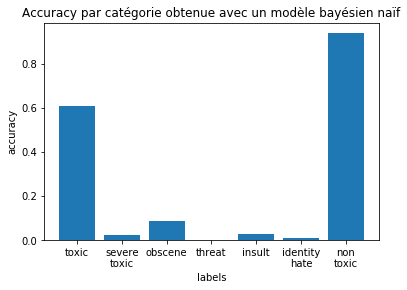

In [12]:
names = ["toxic", "severe\ntoxic", "obscene", "threat", "insult", "identity\nhate", "non\ntoxic"]

plt.bar(names, array_proportion_correct)
plt.xlabel('labels')
plt.ylabel('accuracy')
plt.title("Accuracy par catégorie obtenue avec un modèle bayésien naïf")
plt.savefig("accuracy_toutes_classes_bayésien_simple.png")

In [82]:
# Hamming loss

predictions_hamming = naive_bayes.predict_proba(corpus_test_hamming)
# on supprime la colonne qui correspond à la classe non toxic
predictions_hamming = np.delete(predictions_hamming, -1, axis=1)
# on transforme les probas en labels
predictions_hamming = (predictions_hamming >= 0.5).astype(int)

hamming_loss_simple = hamming_loss(np_labels_test_hamming, predictions_hamming)
print(hamming_loss_simple)

0.0366167536757427


## Modèle bayésien naïf double

### Définition des modèles

In [13]:
# création des données adaptées à ce modèle
# nouveaux labels : 1 : toxique ; 0 : non toxique
np_labels_train_01 = (np_labels_train < 6).astype(int) 

In [14]:
first_bayes = MultinomialNB()
first_bayes.fit(corpus_train, np_labels_train_01)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
# obtention des données uniquement toxiques
indices_6 = np.where(np_labels_train < 6)
corpus_train_6 = list(itemgetter(*indices_6[0])(list_tokens)) 
corpus_train_6 = vectorizer.transform(corpus_train_6)
np_labels_train_6 = np.take(np_labels_train, indices_6[0], axis=0)

In [16]:
second_bayes = MultinomialNB()
second_bayes.fit(corpus_train_6, np_labels_train_6)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Test

In [114]:
# nouveaux labels : 1 : toxique ; 0 : non toxique

# on doit changer les labels du corpus de test en labels binaires
np_labels_test_01 = (np_labels_test < 6).astype(int) 

first_predictions = first_bayes.predict(corpus_test)
index_toxic = np.argwhere(first_predictions == 1) # en 2D

# constitution du corpus de test avec 6 labels en fonction des premières prédictions
corpus_test_6 = list(itemgetter(*index_toxic[:, 0])(list_tokens_test)) 
corpus_test_6 = vectorizer.transform(corpus_test_6)
np_labels_test_6 = np.take(np_labels_test, index_toxic[:, 0], axis=0)

second_predictions = second_bayes.predict(corpus_test_6)

# accuracy pour la classe non toxique
accuracy_7e_classe = accuracy_score(np_labels_test_01, first_predictions)

# accuracy pour les autres classes
comparison_6 = np.equal(np_labels_test_6.reshape((-1, 1)), second_predictions.reshape((-1, 1)))
array_proportion_correct_6 = []
for classe in range(6):
    index_classe = np.where(np_labels_test_6 == classe)  
    array_classe = np.take(comparison_6, index_classe, axis=0).reshape((-1, 1)) 
    nb_correct_pred = np.sum(array_classe) 
    array_proportion_correct_6.append(nb_correct_pred / array_classe.shape[0])

print("accuracy des classes :")
for i in range(6):
    print(i, " : ", array_proportion_correct_6[i])
print("7 : ", accuracy_7e_classe)

accuracy des classes :
0  :  0.8863936591809776
1  :  0.022099447513812154
2  :  0.10531370038412292
3  :  0.0
4  :  0.03600423579244617
5  :  0.0125
7 :  0.9053479711489208


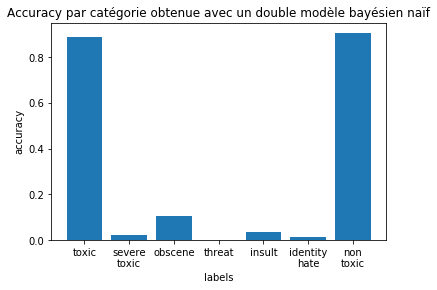

In [19]:
# graphique
names = ["toxic", "severe\ntoxic", "obscene", "threat", "insult", "identity\nhate", "non\ntoxic"]
proportion_correct_bayésien_double = array_proportion_correct_6 + [accuracy_7e_classe.tolist()]

plt.clf
plt.bar(names, proportion_correct_bayésien_double)
plt.xlabel('labels')
plt.ylabel('accuracy')
plt.title("Accuracy par catégorie obtenue avec un double modèle bayésien naïf")
plt.savefig("accuracy_toutes_classes_bayésien_double.png")

In [139]:
# évaluation du modèle binaire
accuracy_binaire = accuracy_score(np_labels_test_01, first_predictions)
precision_binaire = precision_score(np_labels_test_01, first_predictions)
recall_binaire = recall_score(np_labels_test_01, first_predictions)
f1score_binaire = f1_score(np_labels_test_01, first_predictions)

print("évaluation du modèle binaire sans augmentation de données : ")
print("accuracy : ", accuracy_binaire)
print("precision : ", precision_binaire)
print("recall : ", recall_binaire)
print("F1-score : ", f1score_binaire)

évaluation du modèle binaire sans augmentation de données : 
accuracy :  0.9053479711489208
precision :  0.7435930047694753
recall :  0.8065250379362671
F1-score :  0.7737815570922807


In [140]:
# évaluation du deuxième modèle (multinomial)

# constitution du jeu de données uniquement toxique
true_index_toxic = np.argwhere(np_labels_test < 6) 
true_corpus_test_6 = list(itemgetter(*true_index_toxic[:, 0])(list_tokens_test)) 
true_corpus_test_6 = vectorizer.transform(true_corpus_test_6)
np_true_labels_test_6 = np.take(np_labels_test, true_index_toxic[:, 0], axis=0)

predictions_second_model = second_bayes.predict(true_corpus_test_6)

# évaluation 
accuracy_mult = accuracy_score(np_true_labels_test_6, predictions_second_model)
precision_mult = precision_score(np_true_labels_test_6, predictions_second_model, average='weighted')
recall_mult = recall_score(np_true_labels_test_6, predictions_second_model, average='weighted')
f1score_mult = f1_score(np_true_labels_test_6, predictions_second_model, average='weighted')

print("évaluation du modèle multinomial sans augmentation de données : ")
print("accuracy : ", accuracy_mult)
print("precision : ", precision_mult)
print("recall : ", recall_mult)
print("F1-score : ", f1score_mult)

évaluation du modèle multinomial sans augmentation de données : 
accuracy :  0.4148158366671265
precision :  0.3350304121331452
recall :  0.4148158366671265
F1-score :  0.29715465157984966


In [142]:
# hamming loss sur les deux modèles

first_predictions_hamming = first_bayes.predict(corpus_test_hamming)

index_toxic_hamming = np.argwhere(first_predictions_hamming == 1)
list_range = list(range(first_predictions_hamming.shape[0]))
index_non_toxic_hamming = [x for x in list_range if x not in index_toxic_hamming[:, 0]]

# exemples prédits toxiques
corpus_test_hamming_6 = list(itemgetter(*index_toxic_hamming[:, 0])(list_tokens_test_hamming)) 
corpus_test_hamming_6 = vectorizer.transform(corpus_test_hamming_6)
np_labels_test_hamming_6 = np.take(np_labels_test_hamming, index_toxic_hamming[:, 0], axis=0)

# exemples prédits non toxiques
np_labels_test_hamming_7 = np.take(np_labels_test_hamming, index_non_toxic_hamming, axis=0)
first_predictions_hamming_7 = np.zeros((len(index_non_toxic_hamming), 6))

second_predictions_hamming = second_bayes.predict_proba(corpus_test_hamming_6)
second_predictions_hamming = (second_predictions_hamming >= 0.5).astype(int)

# concaténation pour appliquer la hamming loss
predictions_hamming_double = np.vstack((first_predictions_hamming_7, second_predictions_hamming))
np_labels_hamming_double = np.vstack((np_labels_test_hamming_7, np_labels_test_hamming_6))

print("hamming loss sur les exemples prédits toxiques")
print(hamming_loss(np_labels_test_hamming_6, second_predictions_hamming))

hamming_loss_double = hamming_loss(np_labels_hamming_double, predictions_hamming_double)
print("hamming loss sur tous les exemples")
print(hamming_loss_double)

hamming loss sur les exemples prédits toxiques
0.2240715056249037
hamming loss sur tous les exemples
0.03760928235747705


In [143]:
print("hamming loss sur tous les exemples toxiques")
# il faut récupérer les labels pour les vrais exemples toxiques, faire la prédiction_proba, transformer en 0_1
summ = np.sum(np_labels_test_hamming, axis=1)  
index_true_toxic_hamming = np.argwhere(summ > 0)  # 2D, (6243, 1)

corpus_test_true_toxic_hamming = list(itemgetter(*index_true_toxic_hamming[:, 0])(list_tokens_test_hamming)) 
corpus_test_true_toxic_hamming = vectorizer.transform(corpus_test_true_toxic_hamming)
labels_test_true_toxic_hamming = np.take(np_labels_test_hamming, index_true_toxic_hamming[:, 0], axis=0)

predictions_true_toxic_hamming = second_bayes.predict_proba(corpus_test_true_toxic_hamming)
predictions_true_toxic_hamming = (predictions_true_toxic_hamming >= 0.5).astype(int)
print(hamming_loss(labels_test_true_toxic_hamming, predictions_true_toxic_hamming))

hamming loss sur tous les exemples toxiques
0.2550056062790325


# Avec augmentation de données

In [21]:
# si on n'utilise ces fonctions qu'une seule fois, on multiplie par 4 le nombre d'exemples des classes sélectionnées 

# increase the number of examples of severe_toxic, threat, and identity_hate
# ici, on suppose que np_labels est un 1D array
def unique_word_augm(list_tokens, np_labels):
    # get the examples from classes 1, 3, 5 in a new list
    wanted_classes = np.array([1, 3, 5])
    index_classes = np.where(np.in1d(np_labels, wanted_classes))
    wanted_tokens = list(itemgetter(*index_classes[0])(list_tokens))
    wanted_labels = np.take(np_labels, index_classes[0])
    # remove the duplicate words
    for i in range(len(wanted_tokens)):
        spl = wanted_tokens[i].split(" ")
        count = Counter(spl)
        list_unique = list(count.keys())
        wanted_tokens[i] = " ".join(list_unique)
    # add to list_tokens and np_labels
    new_list_tokens = list_tokens + wanted_tokens
    new_np_labels = np.hstack((np_labels, wanted_labels))
    return new_list_tokens, new_np_labels

def random_mask(list_tokens, np_labels):
    # get the examples from classes 1, 3, 5 in a new list
    wanted_classes = np.array([1, 3, 5])
    index_classes = np.where(np.in1d(np_labels, wanted_classes))
    wanted_tokens = list(itemgetter(*index_classes[0])(list_tokens))
    wanted_labels = np.take(np_labels, index_classes[0])
    # créer un masque qui garde 80% des mots (qui en enlève 20%)
    for i in range(len(wanted_tokens)):
        tokens = wanted_tokens[i].split()
        mask = np.random.choice([0, 1], size=(len(tokens),), p=[0.2, 0.8]).astype(bool)  
        new_tokens = list(np.array(tokens)[mask])
        wanted_tokens[i] = " ".join(new_tokens)
    new_list_tokens = list_tokens + wanted_tokens
    new_np_labels = np.hstack((np_labels, wanted_labels))
    return new_list_tokens, new_np_labels


t0 = time.time()
list_tokens_aug, np_labels_train_aug = unique_word_augm(list_tokens, np_labels_train)
list_tokens_aug, np_labels_train_aug = random_mask(list_tokens_aug, np_labels_train_aug)
t1 = time.time()
print("temps : ", t1-t0) 

temps :  0.3855459690093994


## Transformation en matrice

In [83]:
vectorizer_aug = CountVectorizer()

corpus_train_aug = vectorizer_aug.fit_transform(list_tokens_aug)
corpus_test_aug = vectorizer_aug.transform(list_tokens_test) 
corpus_test_hamming_aug = vectorizer_aug.transform(list_tokens_test_hamming)

## Modèle bayésien naïf simple

In [84]:
simple_bayes_aug = MultinomialNB()
simple_bayes_aug.fit(corpus_train_aug, np_labels_train_aug)  

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [85]:
# Prédictions pour du single label 
predictions_aug = simple_bayes_aug.predict(corpus_test_aug)
print("Accuracy score: ", accuracy_score(np_labels_test, predictions_aug))
print("Precision score: ", precision_score(np_labels_test, predictions_aug, average='weighted'))
print("Recall score: ", recall_score(np_labels_test, predictions_aug, average='weighted'))

Accuracy score:  0.8020156991956585
Precision score:  0.7991641353061136
Recall score:  0.8020156991956585


In [131]:
# Prédictions pour du single label classe par classe

np_accuracy_aug = np.hstack((np_labels_test.reshape((-1, 1)), predictions_aug.reshape((-1, 1))))
comparison_aug = np.equal(np_accuracy_aug[:, 0], np_accuracy_aug[:, 1]).reshape((-1, 1))
np_accuracy_aug = np.hstack((np_accuracy_aug, comparison_aug))

array_proportion_correct_aug = []
for classe in range(7):
    index_classe = np.where(np_accuracy_aug[:, 0] == classe) # on récupère tous les indices où on est censé prédire la classe
    array_classe = np.take(np_accuracy_aug, index_classe, axis=0).reshape(-1, 3)
    nb_correct_pred = np.sum(array_classe[:, 2])
    array_proportion_correct_aug.append(nb_correct_pred / array_classe.shape[0])
print(array_proportion_correct_aug)

[0.5686371100164204, 0.26430517711171664, 0.04226496884313194, 0.0, 0.014881820834549168, 0.11095505617977527, 0.9367974365636096]


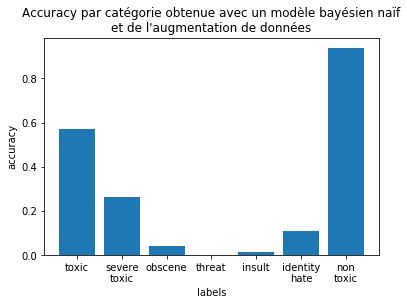

In [116]:
names = ["toxic", "severe\ntoxic", "obscene", "threat", "insult", "identity\nhate", "non\ntoxic"]

plt.bar(names, array_proportion_correct_aug)
plt.xlabel('labels')
plt.ylabel('accuracy')
plt.title("Accuracy par catégorie obtenue avec un modèle bayésien naïf\net de l'augmentation de données")
plt.savefig("accuracy_toutes_classes_bayésien_simple_data_aug.png")

In [88]:
# Hamming loss

predictions_hamming_aug = naive_bayes.predict_proba(corpus_test_hamming_aug)
# on supprime la colonne qui correspond à la classe non toxic
predictions_hamming_aug = np.delete(predictions_hamming_aug, -1, axis=1)
# on transforme les probas en labels
predictions_hamming_aug = (predictions_hamming_aug >= 0.5).astype(int)

hamming_loss_simple_aug = hamming_loss(np_labels_test_hamming, predictions_hamming_aug)
print(hamming_loss_simple_aug)

0.0366167536757427


## Modèle bayésien naïf double

### Définition des modèles

In [27]:
# création des données adaptées à ce modèle
# nouveaux labels : 1 : toxique ; 0 : non toxique
np_labels_train_aug_01 = (np_labels_train_aug < 6).astype(int) 

In [28]:
first_bayes_aug = MultinomialNB()
first_bayes_aug.fit(corpus_train_aug, np_labels_train_aug_01)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
# obtention des données uniquement toxiques
indices_6 = np.where(np_labels_train_aug < 6)
corpus_train_aug_6 = list(itemgetter(*indices_6[0])(list_tokens_aug)) 
corpus_train_aug_6 = vectorizer_aug.transform(corpus_train_aug_6)
np_labels_train_aug_6 = np.take(np_labels_train_aug, indices_6[0], axis=0)

In [30]:
second_bayes_aug = MultinomialNB()
second_bayes_aug.fit(corpus_train_aug_6, np_labels_train_aug_6)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Test

In [101]:
# nouveaux labels : 1 : toxique ; 0 : non toxique
# on doit changer les labels du corpus de test en labels binaires
np_labels_test_01 = (np_labels_test < 6).astype(int) 

first_predictions_aug = first_bayes_aug.predict(corpus_test_aug)
index_toxic = np.argwhere(first_predictions_aug == 1) 

# constitution du corpus de test avec 6 labels en fonction des premières prédictions
corpus_test_aug_6 = list(itemgetter(*index_toxic[:, 0])(list_tokens_test)) 
corpus_test_aug_6 = vectorizer_aug.transform(corpus_test_aug_6)
np_labels_test_6 = np.take(np_labels_test, index_toxic[:, 0], axis=0)

second_predictions_aug = second_bayes_aug.predict(corpus_test_aug_6)

# accuracy pour la classe non toxique
accuracy_7e_classe_aug = accuracy_score(np_labels_test_01, first_predictions_aug)

# accuracy pour les autres classes
comparison_6 = np.equal(np_labels_test_6.reshape((-1, 1)), second_predictions_aug.reshape((-1, 1)))
array_proportion_correct_aug_6 = []
for classe in range(6):
    index_classe = np.where(np_labels_test_6 == classe)  
    array_classe = np.take(comparison_6, index_classe, axis=0).reshape((-1, 1)) 
    nb_correct_pred = np.sum(array_classe)  
    array_proportion_correct_aug_6.append(nb_correct_pred / array_classe.shape[0])

print("accuracy des classes :")
for i in range(6):
    print(i, " : ", array_proportion_correct_aug_6[i])
print("7 : ", accuracy_7e_classe_aug)

accuracy des classes :
0  :  0.835801393728223
1  :  0.2664835164835165
2  :  0.05
3  :  0.0
4  :  0.017919887561489812
5  :  0.12576687116564417
7 :  0.9037835892182243


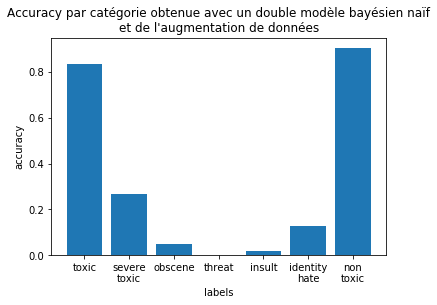

In [102]:
# graphique
names = ["toxic", "severe\ntoxic", "obscene", "threat", "insult", "identity\nhate", "non\ntoxic"]
proportion_correct_bayésien_double_aug = array_proportion_correct_aug_6 + [accuracy_7e_classe_aug.tolist()]

plt.clf
plt.bar(names, proportion_correct_bayésien_double_aug)
plt.xlabel('labels')
plt.ylabel('accuracy')
plt.title("Accuracy par catégorie obtenue avec un double modèle bayésien naïf\net de l'augmentation de données")
plt.savefig("accuracy_toutes_classes_bayésien_double_data_aug.png")

In [144]:
# évaluation du modèle binaire
accuracy_binaire_aug = accuracy_score(np_labels_test_01, first_predictions_aug)
precision_binaire_aug = precision_score(np_labels_test_01, first_predictions_aug)
recall_binaire_aug = recall_score(np_labels_test_01, first_predictions_aug)
f1score_binaire_aug = f1_score(np_labels_test_01, first_predictions_aug)

print("évaluation du modèle binaire avec augmentation de données : ")
print("accuracy : ", accuracy_binaire_aug)
print("precision : ", precision_binaire_aug)
print("recall : ", recall_binaire_aug)
print("F1-score : ", f1score_binaire_aug)

évaluation du modèle binaire avec augmentation de données : 
accuracy :  0.9037835892182243
precision :  0.735286783042394
recall :  0.8134915160711822
F1-score :  0.772414696443775


In [145]:
# évaluation du deuxième modèle (multinomial)

# constitution du jeu de données uniquement toxique
true_index_toxic = np.argwhere(np_labels_test < 6) 
true_corpus_test_6 = list(itemgetter(*true_index_toxic[:, 0])(list_tokens_test)) 
true_corpus_test_aug_6 = vectorizer_aug.transform(true_corpus_test_6)
np_true_labels_test_6 = np.take(np_labels_test, true_index_toxic[:, 0], axis=0)

predictions_second_model_aug = second_bayes_aug.predict(true_corpus_test_aug_6)

# évaluation 
accuracy_mult_aug = accuracy_score(np_true_labels_test_6, predictions_second_model_aug)
precision_mult_aug = precision_score(np_true_labels_test_6, predictions_second_model_aug, average='weighted')
recall_mult_aug = recall_score(np_true_labels_test_6, predictions_second_model_aug, average='weighted')
f1score_mult_aug = f1_score(np_true_labels_test_6, predictions_second_model_aug, average='weighted')

print("évaluation du modèle multinomial avec augmentation de données : ")
print("accuracy : ", accuracy_mult_aug)
print("precision : ", precision_mult_aug)
print("recall : ", recall_mult_aug)
print("F1-score : ", f1score_mult_aug)

évaluation du modèle multinomial avec augmentation de données : 
accuracy :  0.3934335770451097
precision :  0.33596391554845634
recall :  0.3934335770451097
F1-score :  0.2822436317548586


In [146]:
# hamming loss

first_predictions_hamming_aug = first_bayes_aug.predict(corpus_test_hamming_aug)

index_toxic_hamming = np.argwhere(first_predictions_hamming_aug == 1) # en 2D
list_range = list(range(first_predictions_hamming_aug.shape[0]))
index_non_toxic_hamming = [x for x in list_range if x not in index_toxic_hamming[:, 0]]

# exemples prédits toxiques
corpus_test_hamming_aug_6 = list(itemgetter(*index_toxic_hamming[:, 0])(list_tokens_test_hamming)) 
corpus_test_hamming_aug_6 = vectorizer_aug.transform(corpus_test_hamming_aug_6)
np_labels_test_hamming_aug_6 = np.take(np_labels_test_hamming, index_toxic_hamming[:, 0], axis=0)

# exemples prédits non toxiques
np_labels_test_hamming_aug_7 = np.take(np_labels_test_hamming, index_non_toxic_hamming, axis=0)
first_predictions_hamming_aug_7 = np.zeros((len(index_non_toxic_hamming), 6))

second_predictions_hamming_aug = second_bayes_aug.predict_proba(corpus_test_hamming_aug_6)
second_predictions_hamming_aug = (second_predictions_hamming_aug >= 0.5).astype(int)

# concaténation pour appliquer la hamming loss
predictions_hamming_double = np.vstack((first_predictions_hamming_aug_7, second_predictions_hamming_aug))
np_labels_hamming_double = np.vstack((np_labels_test_hamming_aug_7, np_labels_test_hamming_aug_6))
print("hamming loss sur les exemples prédits toxiques")
print(hamming_loss(np_labels_test_hamming_aug_6, second_predictions_hamming_aug))

hamming_loss_double_aug = hamming_loss(np_labels_hamming_double, predictions_hamming_double)
print("hamming loss sur tous les exemples")
print(hamming_loss_double_aug)


hamming loss sur les exemples prédits toxiques
0.22694995702059273
hamming loss sur tous les exemples
0.03868256796607167


# Comparaison des modèles

In [104]:
# comparaison des modèles
print("sans augmentation de données")
print("classe \t modèle simple \t\t modèle double")
for i in range(6):
    print(i, " : ", array_proportion_correct[i], "\t", array_proportion_correct_6[i])
print(6, " : ", array_proportion_correct[6], "\t", accuracy_7e_classe)

sans augmentation de données
classe 	 modèle simple 		 modèle double
0  :  0.6064039408866995 	 0.8863936591809776
1  :  0.021798365122615803 	 0.022099447513812154
2  :  0.08859387699810349 	 0.10531370038412292
3  :  0.0 	 0.0
4  :  0.029763641669098336 	 0.03600423579244617
5  :  0.011235955056179775 	 0.0125
6  :  0.9381137957911145 	 0.9053479711489208


In [34]:
# comparaison des modèles
print("augmentation de données")
print("classe \t modèle simple \t\t modèle double")
for i in range(7):
    print(i, " : ", array_proportion_correct_aug[i], "\t", proportion_correct_bayésien_double_aug[i])

augmentation de données
classe 	 modèle simple 		 modèle double
0  :  0.5686371100164204 	 0.8353148392778512
1  :  0.26430517711171664 	 0.26795580110497236
2  :  0.04226496884313194 	 0.05025608194622279
3  :  0.0 	 0.0
4  :  0.014881820834549168 	 0.018002117896223083
5  :  0.11095505617977527 	 0.125
6  :  0.9367974365636096 	 0.9053479711489208
